<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Notes:" data-toc-modified-id="Notes:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Notes:</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="#Cell-meta" data-toc-modified-id="Cell-meta-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Cell meta</a></span></li><li><span><a href="#MCDS" data-toc-modified-id="MCDS-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>MCDS</a></span></li></ul></li><li><span><a href="#Filter-feature" data-toc-modified-id="Filter-feature-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter feature</a></span><ul class="toc-item"><li><span><a href="#Remove-chromosome" data-toc-modified-id="Remove-chromosome-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Remove chromosome</a></span></li><li><span><a href="#Remove-blacklist-region" data-toc-modified-id="Remove-blacklist-region-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Remove blacklist region</a></span></li><li><span><a href="#Remove-by-mean-cov" data-toc-modified-id="Remove-by-mean-cov-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Remove by mean cov</a></span></li></ul></li><li><span><a href="#Add-mC-rate" data-toc-modified-id="Add-mC-rate-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Add mC rate</a></span></li><li><span><a href="#Select-HVF" data-toc-modified-id="Select-HVF-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Select HVF</a></span><ul class="toc-item"><li><span><a href="#mCH-HVF" data-toc-modified-id="mCH-HVF-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>mCH HVF</a></span></li><li><span><a href="#mCG-HVF" data-toc-modified-id="mCG-HVF-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>mCG HVF</a></span></li></ul></li><li><span><a href="#Get-Anndata" data-toc-modified-id="Get-Anndata-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Get Anndata</a></span><ul class="toc-item"><li><span><a href="#Load-HVF" data-toc-modified-id="Load-HVF-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>Load HVF</a></span></li><li><span><a href="#CH-adata" data-toc-modified-id="CH-adata-10.2"><span class="toc-item-num">10.2&nbsp;&nbsp;</span>CH adata</a></span></li><li><span><a href="#CG-adata" data-toc-modified-id="CG-adata-10.3"><span class="toc-item-num">10.3&nbsp;&nbsp;</span>CG adata</a></span></li></ul></li><li><span><a href="#Prepare-Gene" data-toc-modified-id="Prepare-Gene-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Prepare Gene</a></span></li></ul></div>

# Prepare AnnData and Highly Variable Feature Selection

## Purpose
- Calculate methylation rate
- Normalize per cell and clip extreme
- Highly variable feature (usually 100kb bins) selection
- Prepare HVF adata file
- Prepare gene adata file
- Basically, from N-D MCDS to 2-D anndata.AnnData object

## Notes:
- Usually we use 100kb bins to do clustering and use gene body mCH (for neuron) or mCG (for non-neuron) to annotate clusters.
- Therefore, feature usually refer to chrom100k bins, but you can try to use other feature (e.g. gene) to do clustering.

## Input
- Cell metadata table, MCDS list

## Output
- mCH HVF adata
- mCG HVF adata
- Gene rate MCDS

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy.api as sc
import seaborn as sns
import xarray as xr
from pybedtools import BedTool
from ALLCools.mcds.MCDS import MCDS
from cemba_data.plot import *

In [3]:
result_dir = pathlib.Path('Adata')
result_dir.mkdir(exist_ok=True)
fig_dir = pathlib.Path('fig/feature_selection')
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
in_memory = True
dask_distribute = False

# selected cell metadata path
cell_meta_path = ''

# blacklist
black_list_path = '/home/hanliu/project/mouse_rostral_brain/misc/mm10-blacklist.v2.bed.gz'

# mcds_path
mcds_path_list = ['./RS2_PT.4176cells.raw_count.mcds']

clustering_feature = 'chrom100k'  # usually 100kb chromosome bins or genes

# remove bad features
black_list_region = None
exclude_chromosome = ['chrY', 'chrM']

# preprocess parameters
min_feature_cov, max_feature_cov = 500, 3000

ch_hvf_top = 8000
min_ch_hvf_mean = 0.5
max_ch_hvf_mean = 2.5

generate_gene_rate = True

In [5]:
if dask_distribute:
    from dask.distributed import Client
    client = Client(dashboard_address=':5555')

## Load data
### Cell meta

In [6]:
cell_meta = pd.read_hdf('RS2_PT.4176cells.meta.hdf', key='data')

### MCDS

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    mcds = MCDS.open(mcds_path_list,
                     use_cells=cell_meta.index,
                     chunks={'cell': 1000})
if in_memory:
    mcds.load()

In [8]:
mcds = mcds.expand_dims(mc_type=['CHN'])

In [9]:
mcds

<xarray.MCDS>
Dimensions:       (cell: 4176, chrom100k: 26330, count_type: 2, mc_type: 1)
Coordinates:
  * mc_type       (mc_type) <U3 'CHN'
  * cell          (cell) object 'RS2_0' 'RS2_1' ... 'RS2_4174' 'RS2_4175'
  * chrom100k     (chrom100k) int64 0 1 2 3 4 ... 26344 26345 26346 26347 26348
  * count_type    (count_type) object 'mc' 'cov'
Data variables:
    chrom100k_da  (mc_type, count_type, cell, chrom100k) int64 0 0 0 ... 289 0

### Remove by mean cov

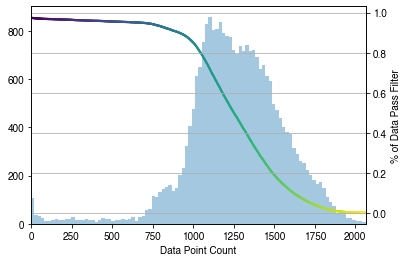

In [10]:
# only calculate CHN
fig, axes = cutoff_vs_cell_remain(mcds[f'{clustering_feature}_da']\
                                  .sel(count_type='cov', mc_type='CHN')\
                                  .mean(axis=0)\
                                  .load())
fig.savefig(fig_dir / f'region_mean_CHN_cov.pdf')

In [11]:
before = mcds.coords[clustering_feature].size
mcds = mcds.filter_region_cov(dim=clustering_feature,
                              da=f'{clustering_feature}_da',
                              mc_type='CHN',
                              min_cov=min_feature_cov,
                              max_cov=max_feature_cov)
after = mcds.coords[clustering_feature].size
print(
    f'Filter {clustering_feature} by [{min_feature_cov}, {max_feature_cov}], '
    f'filter rate {(after / before):.2f}. {after} features remained.')

Filter chrom100k by [500, 3000], filter rate 0.96. 25158 features remained.


In [12]:
mcds

<xarray.MCDS>
Dimensions:       (cell: 4176, chrom100k: 25158, count_type: 2, mc_type: 1)
Coordinates:
  * mc_type       (mc_type) <U3 'CHN'
  * cell          (cell) object 'RS2_0' 'RS2_1' ... 'RS2_4174' 'RS2_4175'
  * chrom100k     (chrom100k) int64 30 31 32 33 34 ... 26335 26336 26337 26338
  * count_type    (count_type) object 'mc' 'cov'
Data variables:
    chrom100k_da  (mc_type, count_type, cell, chrom100k) int64 11 19 ... 1910

## Add mC rate

In [13]:
mcds.add_mc_rate(dim=clustering_feature, da=f'{clustering_feature}_da')

## Select HVF

### mCH HVF

In [14]:
ch_hvf_df = mcds.highly_variable_methylation_feature(
    var_dim=clustering_feature,
    mc_type='CHN',
    min_disp=None,
    max_disp=None,
    min_mean=min_ch_hvf_mean,
    max_mean=max_ch_hvf_mean,
    n_top_feature=ch_hvf_top,
    bin_min_features=5,
    mean_binsize=0.05,
    cov_binsize=100)

Total Feature Number:     25158
Highly Variable Feature:  8000 (31.8%)


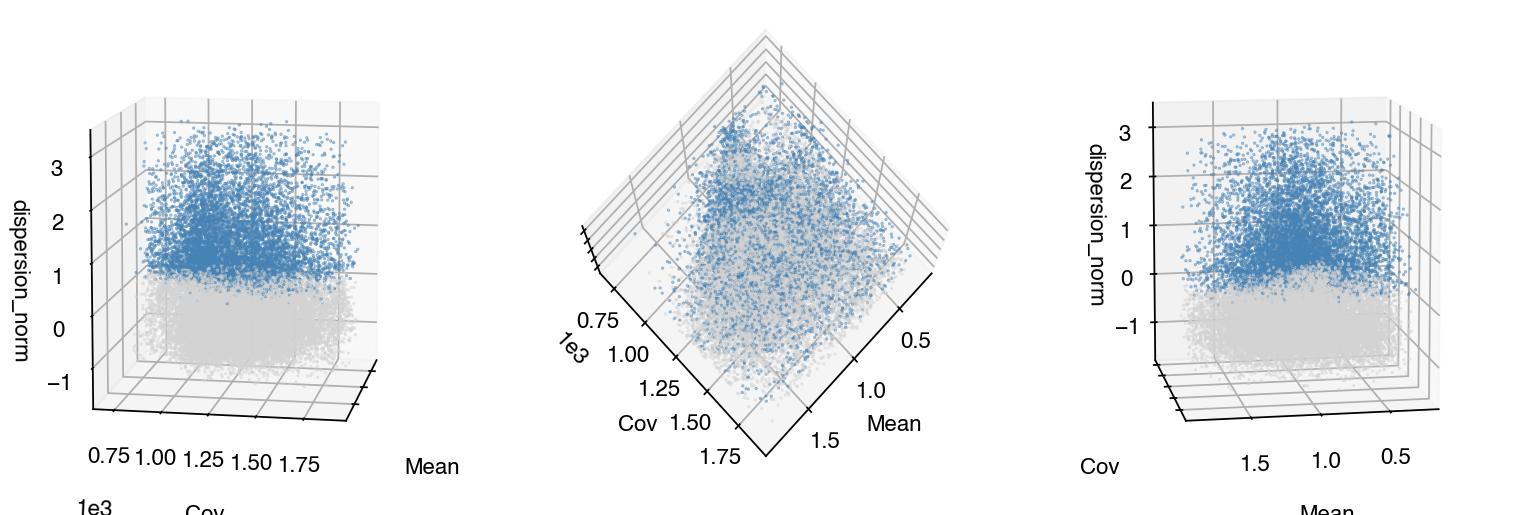

In [15]:
selection = ch_hvf_df['gene_subset']
print(f'Total Feature Number:     {selection.size}')
print(
    f'Highly Variable Feature:  {selection.sum()} ({(selection.sum() / selection.size * 100):.1f}%)'
)

fig, axes = plot_dispersion(ch_hvf_df,
                            hue='gene_subset',
                            zlab='dispersion_norm',
                            data_quantile=(0.01, 0.99),
                            save_animate_path=None,
                            fig_kws=None)
fig.savefig(fig_dir / f'ch_highly_variable_feature.{clustering_feature}.png',
            bbox_inches='tight')

### mCG HVF

## Get Anndata

### Load HVF

In [16]:
selected_ch_feature = ch_hvf_df[ch_hvf_df['gene_subset']].index

mcds = mcds.sel(chrom100k=selected_ch_feature)
mcds['chrom100k_da_rate'].load()

<xarray.DataArray 'chrom100k_da_rate' (mc_type: 1, cell: 4176, chrom100k: 8000)>
array([[[0.67216612, 0.70497869, 1.04173394, ..., 1.05191061,
         0.63966363, 1.45846934],
        [0.67358225, 0.62879077, 0.57318342, ..., 1.27740093,
         2.15115967, 1.30853118],
        [0.7164489 , 1.24246292, 1.346419  , ..., 1.05441301,
         1.        , 0.32725171],
        ...,
        [0.66067864, 0.71189791, 0.72917491, ..., 1.89675481,
         1.91097792, 0.80431069],
        [0.7144339 , 0.89508416, 1.71523328, ..., 0.83236478,
         1.90182471, 1.06086002],
        [0.90967778, 1.3543209 , 1.63224305, ..., 0.8048179 ,
         1.00229133, 1.28026477]]])
Coordinates:
  * mc_type    (mc_type) <U3 'CHN'
  * cell       (cell) object 'RS2_0' 'RS2_1' 'RS2_2' ... 'RS2_4174' 'RS2_4175'
  * chrom100k  (chrom100k) int64 30 31 32 34 36 ... 26330 26331 26337 26338

### CH adata

In [17]:
ch_adata = mcds.sel(chrom100k=selected_ch_feature).to_ann(
    f'{clustering_feature}_da_rate', var_dim=clustering_feature, mc_type='CHN')
ch_adata.write_h5ad(result_dir / 'mch_adata.norm_per_cell.hvf.h5ad')

Transforming to str index.


In [18]:
ch_adata

AnnData object with n_obs × n_vars = 4176 × 8000 